## transfer learning
1、**Finetuning the convnet**：使用预训练的网络初始化网络

2、**ConvNet as fixed feature extractor**：将冻结除最终完全连接层之外的所有网络的权重。最后一个完全连接的层将替换为具有随机权重的新层，并且仅训练该层

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

more:https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### load data

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 可视化

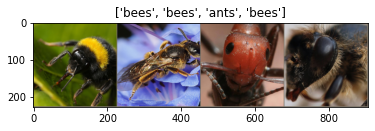

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 训练模型

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 可视化模型预测

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### finetuning convnet

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个周期将LR衰减0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 训练和评估

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6931 Acc: 0.6721
val Loss: 0.2788 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5089 Acc: 0.7910
val Loss: 0.3671 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.8531 Acc: 0.7090
val Loss: 0.2866 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3703 Acc: 0.8484
val Loss: 0.2863 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3823 Acc: 0.8033
val Loss: 0.2630 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5353 Acc: 0.8074
val Loss: 0.3254 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.5451 Acc: 0.7787
val Loss: 0.1950 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3441 Acc: 0.8648
val Loss: 0.2011 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3548 Acc: 0.8402
val Loss: 0.1868 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3154 Acc: 0.8730
val Loss: 0.1752 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2240 Acc: 0.8934
val Loss: 0.1785 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3224 Acc: 0.8525
val Loss: 0.1963 Acc: 0.9020

Ep

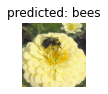

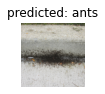

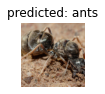

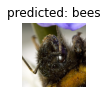

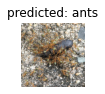

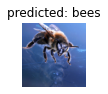

In [8]:
visualize_model(model_ft)

### ConvNet作为固定特征提取器
we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()


In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练和评估

In [10]:
# 训练时间：1m19s -> 53s
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7610 Acc: 0.5451
val Loss: 0.7126 Acc: 0.6340

Epoch 1/24
----------
train Loss: 0.5914 Acc: 0.7664
val Loss: 0.1911 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4834 Acc: 0.7869
val Loss: 0.2700 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.3849 Acc: 0.8402
val Loss: 0.1995 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4059 Acc: 0.7910
val Loss: 0.1745 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.5408 Acc: 0.7787
val Loss: 0.3772 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5421 Acc: 0.7992
val Loss: 0.2453 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3382 Acc: 0.8689
val Loss: 0.2019 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3997 Acc: 0.8361
val Loss: 0.2048 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3041 Acc: 0.8648
val Loss: 0.2135 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4041 Acc: 0.8361
val Loss: 0.1934 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3790 Acc: 0.8484
val Loss: 0.2007 Acc: 0.9477

Ep

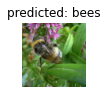

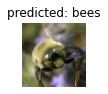

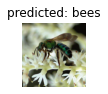

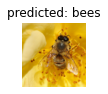

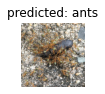

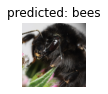

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()